In [1]:
from fastai.conv_learner import *

In [2]:
PATH = "data/"
sz = 299
arch = resnext101_64
bs = 16
label_csv = f"{PATH}labels.csv"

In [3]:
label_df = pd.read_csv(label_csv)
label_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [4]:
label_df.groupby('breed').count().sort_values(by="id", ascending=False)

id
breed                              
scottish_deerhound              126
maltese_dog                     117
afghan_hound                    116
entlebucher                     115
bernese_mountain_dog            114
shih-tzu                        112
great_pyrenees                  111
pomeranian                      111
basenji                         110
samoyed                         109
airedale                        107
tibetan_terrier                 107
leonberg                        106
cairn                           106
beagle                          105
japanese_spaniel                105
australian_terrier              102
blenheim_spaniel                102
miniature_pinscher              102
irish_wolfhound                 101
lakeland_terrier                 99
saluki                           99
papillon                         96
whippet                          95
siberian_husky                   95
norwegian_elkhound               95
pug                              94
chow                             93
italian_greyhound                92
pembroke                         92
...                             ...
german_short-haired_pointer      75
boxer                            75
bull_mastiff                     75
borzoi                           75
pekinese                         75
cocker_spaniel                   74
american_staffordshire_terrier   74
doberman                         74
brittany_spaniel                 73
malinois                         73
standard_schnauzer               72
flat-coated_retriever            72
redbone                          72
border_collie                    72
curly-coated_retriever           72
kuvasz                           71
chihuahua                        71
soft-coated_wheaten_terrier      71
french_bulldog                   70
vizsla                           70
tibetan_mastiff                  69
german_shepherd                  69
giant_schnauzer                  69
walker_hound                     69
otterhound                       69
golden_retriever                 67
brabancon_griffon                67
komondor                         67
briard                           66
eskimo_dog                       66

[120 rows x 1 columns]

In [5]:
val_idxs = get_cv_idxs(label_df.shape[0])

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test', 
                                    bs=bs, val_idxs=val_idxs, suffix='.jpg', tfms=tfms)
data.resize(340, 'tmp')

In [7]:
PIL.Image.open(PATH + data.trn_ds.fnames[0])

In [8]:
learn = ConvLearner.pretrained(arch, data, ps=0.5)

In [9]:
learn.lr_find()

 79%|█████████████████████████████████████▉          | 405/512 [07:01<01:51,  1.04s/it, loss=8]

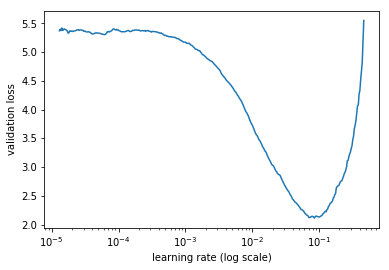

In [10]:
learn.sched.plot()

In [11]:
learn.fit(2e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                      
    0      0.654294   0.28801    0.91047   
    1      0.579549   0.260391   0.913894                                                      
    2      0.389199   0.226827   0.917808                                                      
    3      0.495563   0.293409   0.91047                                                       
    4      0.435354   0.230414   0.927104                                                      
    5      0.280169   0.23154    0.928082                                                      
    6      0.254334   0.225798   0.924168                                                      


[array([0.2258]), 0.9241682975726119]

In [12]:
# learn.unfreeze()
# learn.bn_freeze(True)
# learn.fit([1e-5, 1e-4, 1e-2], 3, cycle_len=1)
# GPU runs out of memory

In [13]:
log_preds, y = learn.TTA()
log_preds

array([[[-15.44878, -15.77208, -10.08567, ..., -14.68058, -16.73292, -14.53921],
        [-15.43258, -12.82962, -12.60573, ..., -10.16806, -13.28026, -13.86473],
        [-20.26596, -19.07971, -16.1805 , ..., -15.26453, -18.06454, -23.28135],
        ...,
        [-14.45166, -12.05608, -14.13606, ..., -12.08621,  -8.26482, -16.19229],
        [-22.15952, -24.96617, -25.97656, ..., -28.98651, -13.69389, -20.18089],
        [-25.32832, -27.4628 , -22.74221, ..., -20.04594, -26.86295, -28.03991]],

       [[-14.87701, -15.6324 ,  -8.7791 , ..., -13.49514, -15.90115, -14.67468],
        [-17.94701, -14.03506, -15.31941, ..., -11.83525, -15.74279, -16.03815],
        [-18.30024, -17.08482, -13.38903, ..., -13.05202, -16.23348, -21.19473],
        ...,
        [-16.27276, -15.82309, -18.56911, ..., -16.20228, -12.48416, -18.23525],
        [-21.00585, -24.14201, -24.47871, ..., -27.24276, -12.14701, -19.75667],
        [-24.73946, -27.77444, -20.89932, ..., -21.65776, -25.66216, -28.11829]],

In [14]:
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9315068493150684

In [16]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [17]:
df = pd.DataFrame(probs)
df.columns = data.classes
df

affenpinscher  afghan_hound  african_hunting_dog      airedale  \
0       3.235900e-07  7.244499e-07         1.999493e-07  6.167537e-09   
1       1.610413e-08  3.876132e-10         2.819779e-09  1.415861e-09   
2       6.008414e-11  4.753471e-08         9.012149e-09  2.901181e-09   
3       1.083696e-02  3.898954e-06         1.170353e-05  4.715775e-05   
4       5.273224e-01  2.182658e-05         3.401397e-06  1.319163e-06   
5       8.580437e-04  1.173260e-01         1.201075e-03  4.013848e-02   
6       2.071308e-08  5.114246e-09         2.033194e-08  6.654458e-08   
7       2.409590e-07  5.204716e-08         4.793620e-07  4.111004e-07   
8       1.968840e-05  2.379510e-06         3.310516e-04  2.539625e-05   
9       3.623093e-08  8.478053e-08         3.931961e-09  1.024198e-07   
10      9.952744e-07  2.536748e-06         8.158734e-08  1.528809e-07   
11      3.063087e-08  2.968556e-08         5.637033e-09  3.789030e-09   
12      3.252564e-08  3.414199e-08         2.233128e-08  2.098385e-10   
13      1.310193e-06  6.043284e-08         1.718033e-05  4.146867e-05   
14      1.595591e-07  4.201689e-07         1.492684e-07  4.753199e-06   
15      1.735557e-07  4.198384e-06         1.415001e-04  9.913670e-08   
16      1.568317e-06  7.850807e-07         1.925406e-06  8.192156e-08   
17      1.460645e-05  2.330306e-04         3.484758e-05  1.291777e-03   
18      7.810097e-08  3.456524e-06         1.485627e-06  1.146363e-03   
19      9.121937e-11  5.821342e-04         1.243381e-10  9.659438e-10   
20      1.866387e-05  6.268330e-08         2.381651e-07  2.540441e-08   
21      1.312945e-07  8.372055e-06         3.745203e-05  2.342880e-06   
22      1.245198e-07  5.324630e-09         4.291207e-09  1.565254e-10   
23      6.526881e-08  4.308871e-08         1.947575e-08  3.123189e-07   
24      2.159929e-07  3.653873e-05         5.371303e-08  5.989291e-07   
25      3.118485e-11  7.973779e-09         4.596508e-12  6.849490e-11   
26      7.480102e-08  1.513329e-06         1.227276e-06  3.981439e-06   
27      4.480825e-08  1.468563e-05         1.747357e-05  6.543211e-07   
28      1.044358e-09  1.305954e-08         1.443366e-10  1.307551e-09   
29      1.841908e-06  5.659246e-06         9.688995e-07  5.988576e-01   
...              ...           ...                  ...           ...   
10327   1.197187e-05  2.463234e-07         4.522619e-06  1.231024e-04   
10328   3.965983e-07  4.566390e-08         2.577612e-06  1.736040e-07   
10329   8.884141e-10  1.502352e-09         4.667867e-08  2.236614e-08   
10330   6.177985e-08  6.206982e-08         1.395402e-08  1.330047e-08   
10331   1.360522e-07  4.734349e-07         1.414171e-07  7.035354e-08   
10332   8.277613e-07  3.243349e-07         7.069883e-06  3.435737e-06   
10333   1.216421e-09  6.468452e-09         2.320256e-09  5.774791e-07   
10334   3.736537e-07  4.753690e-06         1.222638e-05  2.389924e-07   
10335   1.106314e-08  7.370491e-08         6.649290e-06  3.343780e-09   
10336   1.363521e-04  9.075144e-06         9.938892e-07  5.780221e-01   
10337   8.264336e-10  1.765035e-09         2.221043e-10  1.840720e-09   
10338   5.975928e-07  1.808708e-06         5.074168e-07  1.898563e-05   
10339   1.395974e-06  9.747944e-07         4.404405e-06  2.129254e-06   
10340   2.769266e-08  1.846754e-07         6.530517e-09  9.017677e-08   
10341   7.615919e-07  1.409783e-07         1.317470e-06  7.369417e-07   
10342   1.910318e-08  7.298729e-07         5.162015e-06  3.275263e-07   
10343   8.510494e-12  5.403171e-12         1.066310e-11  5.402524e-06   
10344   2.926253e-05  9.028708e-04         1.442679e-05  3.244055e-05   
10345   6.880097e-07  2.073654e-07         5.016337e-06  3.608432e-08   
10346   8.499261e-06  3.640274e-08         2.084570e-08  2.231321e-08   
10347   7.453068e-10  7.112558e-08         6.321813e-06  2.000111e-08   
10348   4.965819e-07  5.589711e-07         1.109221e-06  9.739357e-07   
10349   6.087046e-11  1.018752e-08         4.801876e-10  2.616116

In [18]:
df.idxmax(axis=1)

0                   japanese_spaniel
1                            samoyed
2                     english_setter
3                                pug
4                      affenpinscher
5                    standard_poodle
6                 australian_terrier
7                            samoyed
8                    irish_wolfhound
9                     sussex_spaniel
10                   tibetan_terrier
11                  sealyham_terrier
12                      newfoundland
13                   norwich_terrier
14                            beagle
15                          leonberg
16                       toy_terrier
17                kerry_blue_terrier
18                     irish_terrier
19                            saluki
20                    scotch_terrier
21                    siberian_husky
22                  mexican_hairless
23                labrador_retriever
24                      irish_setter
25                       groenendael
26                        bloodhound
2

In [19]:
data.test_ds.fnames[0]

'test\\000621fb3cbb32d8935728e48679680e.jpg'

In [20]:
df.insert(0, 'id', [s[5:-4] for s in data.test_ds.fnames])
df

id  affenpinscher  afghan_hound  \
0      000621fb3cbb32d8935728e48679680e   3.235900e-07  7.244499e-07   
1      00102ee9d8eb90812350685311fe5890   1.610413e-08  3.876132e-10   
2      0012a730dfa437f5f3613fb75efcd4ce   6.008414e-11  4.753471e-08   
3      001510bc8570bbeee98c8d80c8a95ec1   1.083696e-02  3.898954e-06   
4      001a5f3114548acdefa3d4da05474c2e   5.273224e-01  2.182658e-05   
5      00225dcd3e4d2410dd53239f95c0352f   8.580437e-04  1.173260e-01   
6      002c2a3117c2193b4d26400ce431eebd   2.071308e-08  5.114246e-09   
7      002c58d413a521ae8d1a5daeb35fc803   2.409590e-07  5.204716e-08   
8      002f80396f1e3db687c5932d7978b196   1.968840e-05  2.379510e-06   
9      0036c6bcec6031be9e62a257b1c3c442   3.623093e-08  8.478053e-08   
10     0041940322116ae58c38130f5a6f71f9   9.952744e-07  2.536748e-06   
11     0042d6bf3e5f3700865886db32689436   3.063087e-08  2.968556e-08   
12     004476c96f575879af4af471af65cae8   3.252564e-08  3.414199e-08   
13     00485d47de966a9437ad3b33ac193b6f   1.310193e-06  6.043284e-08   
14     00496f65de6cc319145ce97bd6e90360   1.595591e-07  4.201689e-07   
15     004bf14426d1a830d459a9e0c0721309   1.735557e-07  4.198384e-06   
16     004c3721eb88358f462cdcec6b2380b7   1.568317e-06  7.850807e-07   
17     00559f56aab7e0a7749220f6aed65162   1.460645e-05  2.330306e-04   
18     005b281f1a4d6f29d527c9585e9bd33c   7.810097e-08  3.456524e-06   
19     005b6c6c76fefd6b458ef6fb6e54da6e   9.121937e-11  5.821342e-04   
20     006870b49353779b25eeb91fed43c31a   1.866387e-05  6.268330e-08   
21     0068f3a21b159ece126a28580cdad7a0   1.312945e-07  8.372055e-06   
22     0069b1cc4546fc98f84f981bf9a0696a   1.245198e-07  5.324630e-09   
23     0077bc3c63486ff09d3774d956af8f76   6.526881e-08  4.308871e-08   
24     00780e5d2bf4f7e4b5f96d08ddde669a   2.159929e-07  3.653873e-05   
25     007ed71136966728f5c0936e23c8286b   3.118485e-11  7.973779e-09   
26     0081831ceb49cd64212c32b884036b82   7.480102e-08  1.513329e-06   
27     00846c0edd5aa4f10ee5e9b84d7310a6   4.480825e-08  1.468563e-05   
28     0092bd9e90a13403373fc0e9e1218938   1.044358e-09  1.305954e-08   
29     009a3c4f6626e4750f74ceb8e8ed8760   1.841908e-06  5.659246e-06   
...                                 ...            ...           ...   
10327  ff7e00f66ebf0042c5ccb74170eecb1a   1.197187e-05  2.463234e-07   
10328  ff8c3ee47324ecf110e147f29747952a   3.965983e-07  4.566390e-08   
10329  ff8f9a768544fda79ffad62576f4d129   8.884141e-10  1.502352e-09   
10330  ff8ff2e36aa2a20d5d8585e2f686dbda   6.177985e-08  6.206982e-08   
10331  ff9742bc22b5830176e85490cf54cdf7   1.360522e-07  4.734349e-07   
10332  ff9b317696e29ca8cd27da30a896edcd   8.277613e-07  3.243349e-07   
10333  ffa316c6db0919d6bad1a5ed483e6722   1.216421e-09  6.468452e-09   
10334  ffa76e07dc686174c2a55fdbdca68bb3   3.736537e-07  4.753690e-06   
10335  ffadae851b94ece57602da7edf72d689   1.106314e-08  7.370491e-08   
10336  ffb3a78e4a162c173219194687eb6054   1.363521e-04  9.075144e-06   
10337  ffb55dbaa32939c109ef42df0668e077   8.264336e-10  1.765035e-09   
10338  ffb68ded4a2247b3c011840ece0a605c   5.975928e-07  1.808708e-06   
10339  ffb8bceeac5b3f587f67391ad346d454   1.395974e-06  9.747944e-07   
10340  ffbb6663b38e903dbd1efa5dce2d0bbb   2.769266e-08  1.846754e-07   
10341  ffbcda9eb84339cc5be15fd9900596a2   7.615919e-07  1.409783e-07   
10342  ffbcf032231bb0b025f9070d42ab7e8f   1.910318e-08  7.298729e-07   
10343  ffc0233904f4d03afe1484be791e09d6   8.510494e-12  5.403171e-12   
10344  ffd06687c72445b0c6e8a130a0a8711a   2.926253e-05  9.028708e-04   
10345  ffd304c521f43819f3824177fd9efeb0   6.880097e-07  2.073654e-07   
10346  ffd3ce0566df4be8049c767a329faaf7   8.499261e-06  3.640274e-08   
10347  ffd87c3e44faa0e3ee5fbbdc4c63b59b   7.453068e-10  7.112558e-08   
10348  ffe2315cf566e039516f5a4a5e52ff1b   4.965819e-07  5.589711e-07   
10349  ffe42f4b4c50d4f18c2b34500f391152   6.087046e-11  1.018752e-08   
10350  ffe563b1b8c0dcd0797c4362c6754b96   1.873170e-05  1.923642e-06   
10351

In [21]:
df.to_csv('submission.csv', index=False)